In [2]:
import lightgbm
from testbed.models.treeffuser import Treeffuser
from treeffuser import treeffuser as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


from numpy.random import PCG64
from _generator import CustomRandomGenerator, CIG_conditional_density, gamma_density

sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
mpl.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],  # ["Computer Modern"],  #
        "font.size": 12,
    }
)

In [3]:
rng = CustomRandomGenerator(PCG64(seed=0))


def p_atom_fn(x):
    return 0.1


shape = 2
scale = 1
n = 20 * 10**3

x, y = rng.CIG(p_atom_fn, shape=shape, scale=scale, size=n)

model = tf.LightGBMTreeffuser(
    sde_initialize_with_data=True,
    n_estimators=10000,
    num_leaves=1000,
    early_stopping_rounds=50,
    learning_rate=0.1,
    # verbose=2,
)
# model = Treeffuser()
fit = model.fit(X=x.reshape(-1, 1), y=y.reshape(-1, 1))

## Figure 1

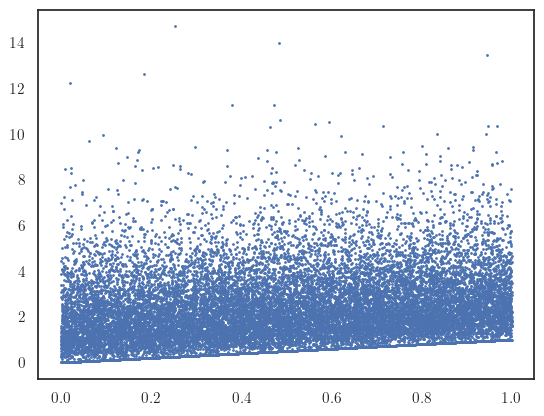

In [4]:
plt.scatter(x, y, s=1)

## Figure 2

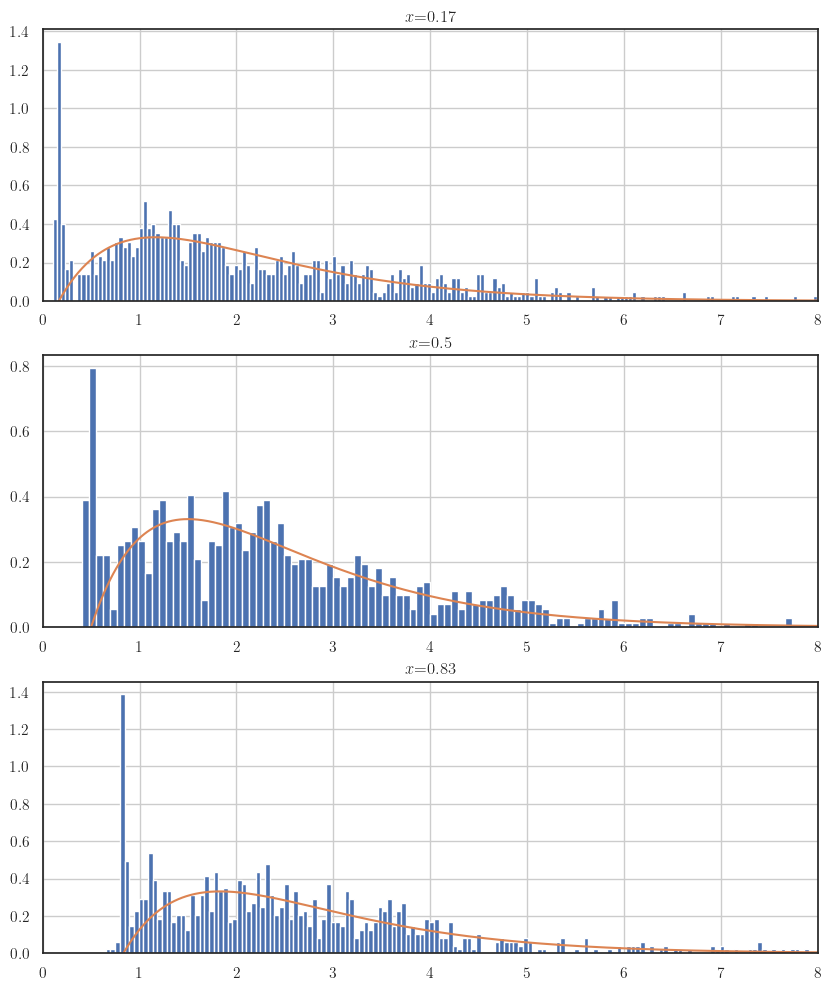

In [28]:
X = (np.array([1, 3, 5]) / 6).reshape(-1, 1)
bandwidhts = [0.1, 0.09, 0.045]
y_lims = [(0, 8), (0, 8), (0, 8)]

fig, axs = plt.subplots(3, 1, figsize=(10, 12))
for i, bw in enumerate(bandwidhts):
    y_plot = np.linspace(y_lims[i][0], y_lims[i][1], 1000).reshape(-1, 1)

    y_samples = model.sample(X[i].reshape(1, 1), n_samples=10**3)
    axs[i].hist(y_samples.reshape(-1), bins=300, density=True)

    density_true = CIG_conditional_density(
        x=X[i], p_atom=p_atom_fn(X[i]), shape=shape, scale=scale
    )
    density_true = density_true(y_plot)
    density_true = np.where(density_true == 0, None, density_true)
    axs[i].plot(y_plot, density_true, label="true")

    # plt.legend()
    axs[i].set_xlim(y_lims[i][0], y_lims[i][1])
    axs[i].set_title(f"$x$={np.round(X[i], 2).item()}")
    axs[i].grid()

## Figure 3

In [6]:
X = (np.array([1, 3, 5]) / 6).reshape(-1, 1)

n_samples = 10**3
x_vals = []
y_samples = []
for x in X:
    x_vals.extend([np.round(x, 2)] * n_samples)
    samples = model.sample(x.reshape(1, 1), n_samples=n_samples).reshape(-1).tolist()
    y_samples.extend(samples)

df = pd.DataFrame({"x": x_vals, "y": y_samples})
df["x"] = df["x"].astype("float")

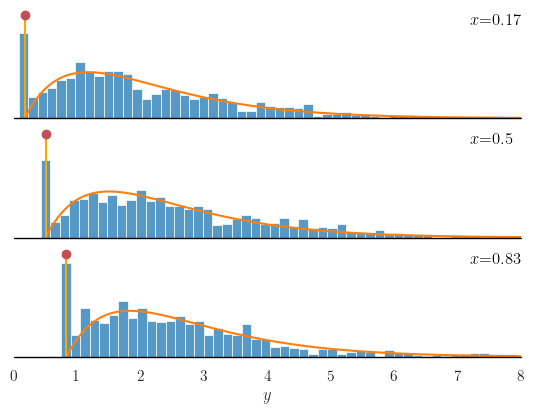

In [26]:
colors = {"blue": "#1f77b4", "orange": "#ff7f0e"}
histogram_color = colors["blue"]
density_color = colors["orange"]
binwidth = 0.15

# Initialize the FacetGrid object
g = sns.FacetGrid(df, row="x", aspect=4, height=1.5, palette=None, sharey=False)

# Draw histograms
g.map(
    sns.histplot,
    "y",
    bins=100,
    binwidth=binwidth,
    kde=False,
    stat="density",
    color=histogram_color,
    linewidth=0.5,
)


# Define a function to plot the curve on top of the histogram
def plot_curve(**kwargs):
    data = kwargs["data"]
    y = data["y"].values
    x_val = data["x"].iloc[0]
    density_true = CIG_conditional_density(
        x=x_val, p_atom=p_atom_fn(x_val), shape=shape, scale=scale
    )
    density_true = density_true(y)
    density_true = np.where(density_true == 0, None, density_true)
    sorted_indices = np.argsort(y)
    plt.plot(y[sorted_indices], density_true[sorted_indices], color=density_color)
    plt.stem(
        [x_val],
        [p_atom_fn(x_val) / ((1 - p_atom_fn(x_val)) * binwidth)],
        linefmt="orange",
        markerfmt="ro",
        basefmt="g-",
    )


g.map_dataframe(plot_curve)

# Color horizontal axis in black
g.refline(y=0, linewidth=1, linestyle="-", color="black", clip_on=False)
g.set(xlabel="$y$")
g.set(xlim=[0, 8])


# Define and use a simple function to label the plot in axes coordinates
def label(**kwargs):
    ax = plt.gca()
    data = kwargs["data"]
    x_val = data["x"].iloc[0]
    ax.text(
        0.9,
        0.9,
        f"$x$={x_val}",
        color="black",  # Set label color to black
        ha="left",
        va="center",
        transform=ax.transAxes,
    )


g.map_dataframe(label)

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=+0.1)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")

# Remove vertical lines
g.despine(bottom=True, left=True)

g.savefig("fig/branching_mixture.pdf", format="pdf", dpi=600)